# James Chukwuka Tabansi
# Background and Context
- Covid-19 is a fast-growing disease that affects human health severely. Patients diagnosed with this condition suffer from lung infections. The medical community has recently released vaccines that have a slower effect in increasing immunity. This virus has impacted various countries\' human health and financial standards.

- Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.

# Objective
- The aim of this project is two folds:

  - Build a deep learning model  to differentiate an X-ray image of a normal person from an unhealthy one.
  - Build an app using Streamlit for users to make predictions or inference using your model.

# Data Description
- This dataset contains training set images of 3 classes which are converted into numpy arrays.
- The dataset comprises 3 classes:
  - COVID-19: The patient who is affected due to covid.
  - Viral Pneumonia: This is a viral fever that has similar characteristics to Covid but is not covid.
  - Normal- A healthy Person.
- The data file names are:
  - CovidImages.npy
  - CovidLabels.csv
- Due to the large volume of data, the images were converted to the CovidImages.npy file and the labels are also put into CovidLabels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.

## Metric to optimize
- the following metrics will be considered
  - 1. ROC-AUC (on a 1-vs-all basis, since this is multi-label classification)
  - 2. Categorical Accuracy


## Import Relevant Packages

In [ ]:
import numpy as np #for computations
import pandas as pd #to read the data
from google.colab.patches import cv2_imshow #to display images
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization
import cv2 #for image manipulation
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential #to deine model struction
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D #for building layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for transfer learning
from tensorflow.keras.optimizers import Adam, SGD #to perform optimization operation during backward prop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #to implement earlystopping and save best models
from tensorflow.keras.metrics import Accuracy,Recall, AUC, Precision, F1Score #for computing metrics
from sklearn.metrics import classification_report, confusion_matrix #for computing metrics
from sklearn.model_selection import train_test_split #to split the data


## Connect Google Drive

In [ ]:
from google.colab import drive
#mount drive
drive.mount('./Drive/')

Mounted at ./Drive/


## Load the Images

In [ ]:
img_path = '/content/Drive/MyDrive/Covid_Image_Classification_Project/CovidImages.npy'
images = np.load(img_path)

## Load the Labels

In [ ]:
label_path = '/content/Drive/MyDrive/Covid_Image_Classification_Project/CovidLabels.csv'
labels = pd.read_csv(label_path)

## EDA

In [ ]:
## check to ensure uniformity of all the images in the data
img_list = []  #create an empty list object to store the shape of all the iamges
for img in images: #loop accross the images
  img_list.append(img.shape) #write the shape of each image to the image list

img_series = pd.Series(img_list) #convert the list to a series object

img_series.unique() #check the unique value in the series

array([(128, 128, 3)], dtype=object)

- this shows that all the images are of size 128 by 128 with 3 channels each (all colored).

In [ ]:
images.shape

(251, 128, 128, 3)

- there are 251 imges in the data

In [ ]:
labels.shape

(251, 1)

- there are 251 corresponding observation in the label

## Visualizing the Image using opencv (CV2)



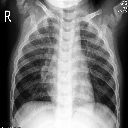

In [ ]:
cv2_imshow(images[0])

## Visualizing the Image using Matplotlib


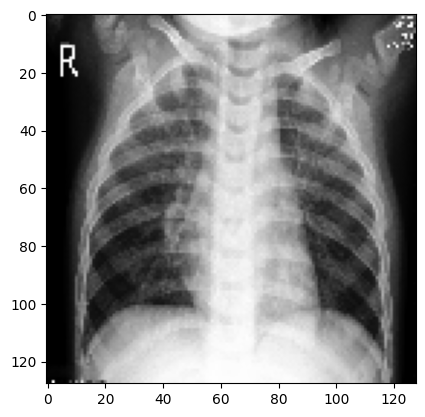

In [ ]:
plt.imshow(images[0])

- opencv reads images in BGR format. I will convert it RGB format using the function below

In [ ]:
def format_conv(image):
  """
  this function converts an image from BGR format (commonly used by opencv) to RGB format
  image: image file
  """
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


In [ ]:
images = [format_conv(img) for img in images]

## Visualize the 3 Image categories in the data

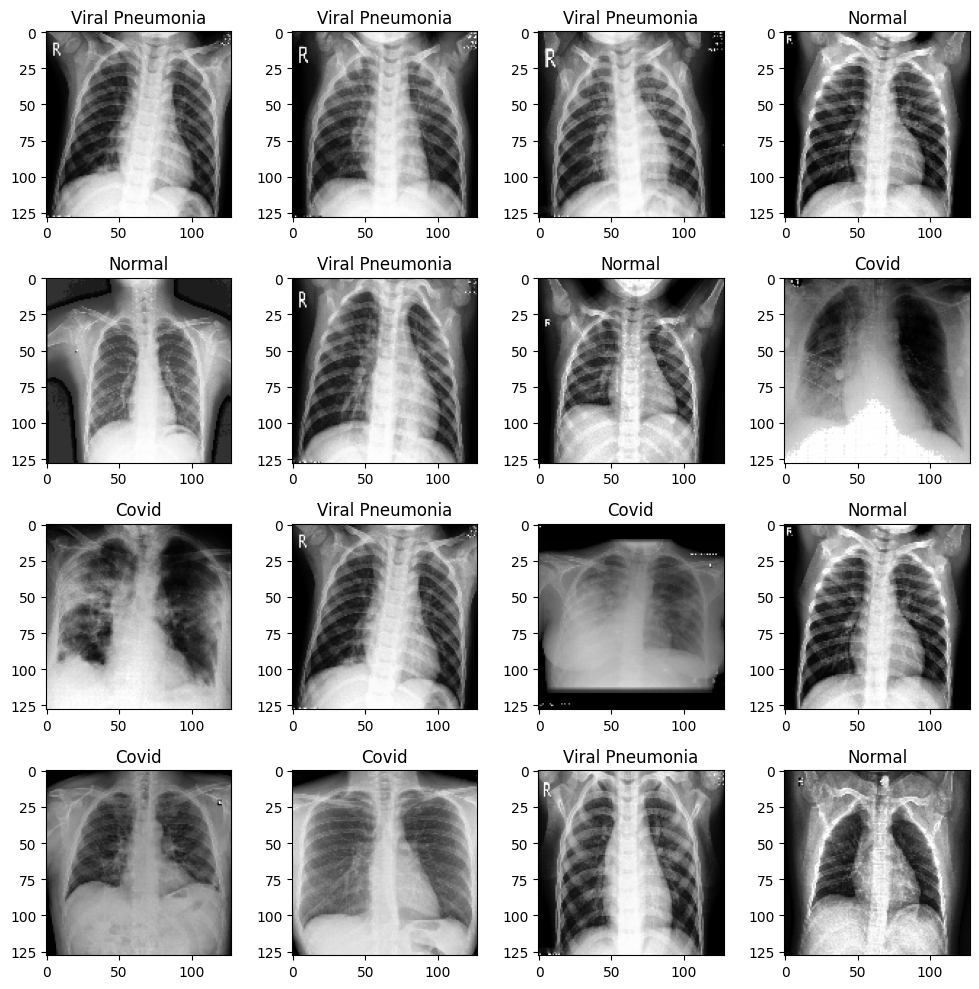

In [ ]:

def cat_viewer(images, labels):
  """
  this fn returns a 4by4 subplot that dispalys the images and the category as title
  """
  import random
  #define a figure
  fig = plt.figure(figsize=(10,10))
  nrows=4 #number of rows
  ncols = 4 #number of columns

  for x in range(nrows):
    for y in range(ncols):
      random_int = random.randint(0, len(labels)) #generate a randomm number
      ax = plt.subplot(nrows, ncols, x * ncols + y + 1) #create a subplot in specified axs
      ax= plt.imshow(images[random_int]) #display the image in the subplot
      plt.title(labels['Label'][random_int])#set the title as the label
  plt.tight_layout()#pad the layout

  plt.show()#display the plot

cat_viewer(images, labels)

In [ ]:
from google.colab import files

functions = files.upload()

In [ ]:
from utils_edited import labeled_barplot

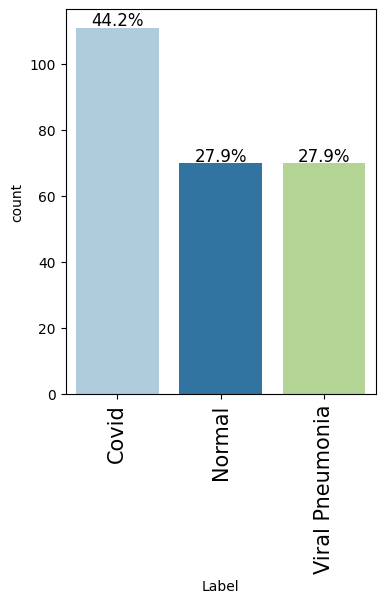

In [ ]:
labeled_barplot(labels, feature='Label', perc=True)

- The dataset is imbalanced as the Covid labels are more than that of Viral Pneumonia and Normal.

## Image Preprocessing
- this refers to 3 methods that we will apply to the images. They are:
    - Resizing:
      - the images will be resized to 32 by 32. This is mainly due to computational constraints
    - Blur
      - to reduce the noise in the images
    - Image pixel normalization
      - this refers to bring all pixel values to a similar range by dividing by 255

In [ ]:
def image_preprocessing(images, ksize=(3,3), dsize=(32,32)):
  """
  preprocesses the images by reducing the size and implementing gaussianblur
  image: images from the dataset
  ksize: (Tuple)kernel size for gaussianblur
  dsize: (Tuple) size of the image
  """
  resized_images = [] #empty list to store images
  blur_images = [] #empty list to store images
  for i in range(len(images)): #loop over the images
    resized_images.append(cv2.resize(images[i], dsize=dsize, interpolation=cv2.INTER_AREA)) #resize the images and store it in the resize list

  for i in range(len(resized_images)): #loop over resized images
    blur_images.append(cv2.GaussianBlur(resized_images[i], ksize=ksize, sigmaX=0)) #blur the images

  # Normalizing the image pixels
  image_normalized = np.array(blur_images).astype('float32')/255.0

  return image_normalized

In [ ]:
image_normalized = image_preprocessing(images)

In [ ]:
image_normalized.shape

(251, 32, 32, 3)

- the size of the images have been reduced.

## View the preproceesed images

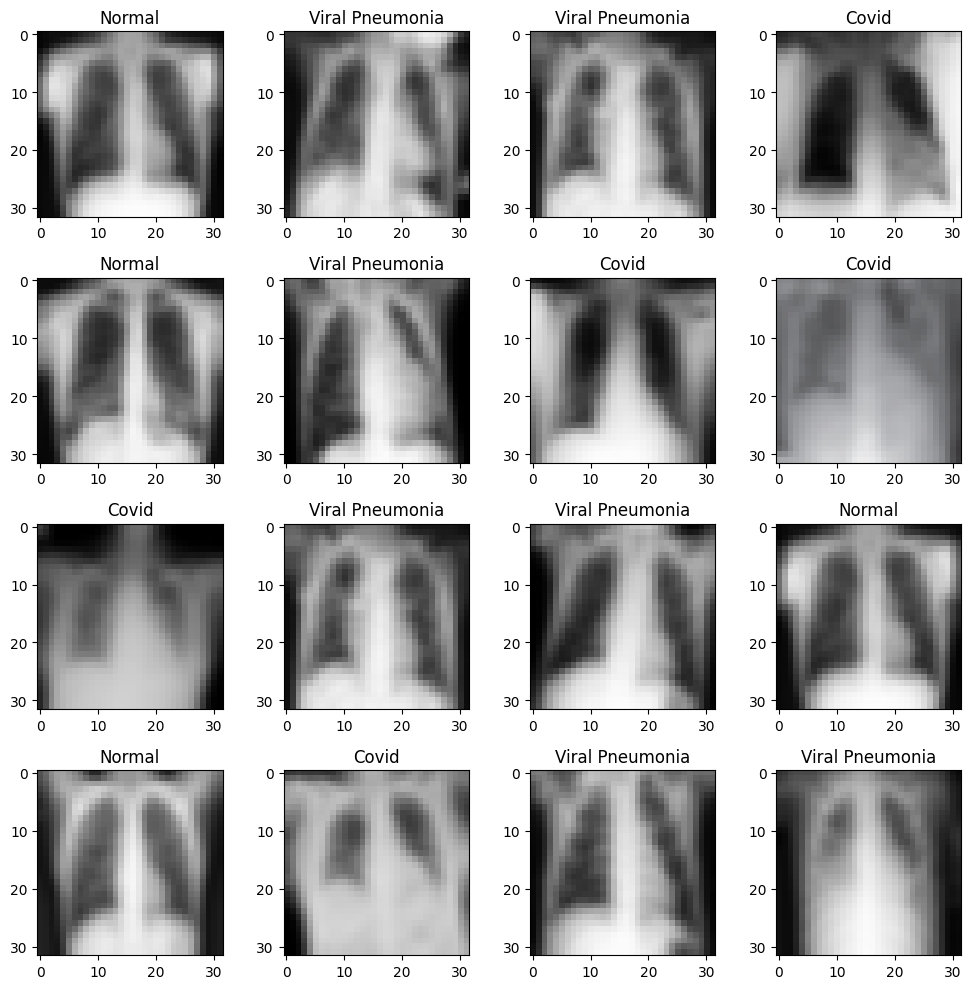

In [ ]:
cat_viewer(image_normalized, labels)

## Split the Dataset into Train and Test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_normalized,labels, train_size=0.8, stratify=labels)

## Encode the Labels

In [ ]:
from sklearn.preprocessing import LabelBinarizer #to  encode the target

In [ ]:
lb = LabelBinarizer() #initialize the label binarizer

y_train_en = lb.fit_transform(y_train)
y_test_en = lb.transform(y_test)

## Save the encoder with pickle

In [ ]:
# import pickle

# with open('/content/Drive/MyDrive/Covid_Image_Classification_Project/label_binarizer.pkl', mode='wb') as LabelBin:
#   pickle.dump(lb, LabelBin)

## Model Development
- I will do this by using a Conv2D layer with 128 kernels of size: 3,3. I will aet padding as 'same.' an AveragePooling layer to reduce the dimension, a Flatten layer, a dense layer with 32 neurons and another dense layer for classification.

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def simpleConv(input_shape=(32,32,3), y_train=y_train):
  #define the metrics
  Met = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      ]
  model = Sequential()

  model.add(Conv2D(128, (3,3), padding='same', input_shape = input_shape, activation = 'relu'))

  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=32, activation='relu'))

  # Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem
  model.add(Dense(units=len(np.unique(y_train)), activation = 'softmax'))

  adam = Adam()

  model.compile(loss='categorical_crossentropy', metrics=[Met], optimizer=adam)

  model.summary()

  return model

In [ ]:
simple_Conv = simpleConv()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 average_pooling2d (Average  (None, 16, 16, 128)       0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1052291 (4.01 MB)
Trainable params: 1052291 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

## Define the Model call backs

In [ ]:
es = EarlyStopping(monitor='recall', mode='max', verbose=2, patience=3)

#define modelcheckpoint to save best model
path = '/content/Drive/MyDrive/Covid_Image_Classification_Project/model.h5'
simp_cov_mc = ModelCheckpoint(filepath = os.path.join(path, 'simp_cov_model'), save_best_only=True, monitor='val_auc', mode='max')

## Train the network

In [ ]:
history = simple_Conv.fit(x_train, y_train_en, epochs=10, validation_split=0.1, callbacks= [es, simp_cov_mc], batch_size=32, verbose=2)

Epoch 1/10
6/6 - 4s - loss: 0.9592 - accuracy: 0.5333 - precision: 0.7303 - recall: 0.3611 - auc: 0.7504 - val_loss: 0.9070 - val_accuracy: 0.5500 - val_precision: 0.5882 - val_recall: 0.5000 - val_auc: 0.7413 - 4s/epoch - 650ms/step
Epoch 2/10
6/6 - 2s - loss: 0.6926 - accuracy: 0.7000 - precision: 0.7452 - recall: 0.6500 - auc: 0.8649 - val_loss: 0.3431 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000 - val_auc: 0.9813 - 2s/epoch - 279ms/step
Epoch 3/10
6/6 - 0s - loss: 0.5525 - accuracy: 0.7444 - precision: 0.7485 - recall: 0.7111 - auc: 0.9088 - val_loss: 0.4248 - val_accuracy: 0.7500 - val_precision: 0.8333 - val_recall: 0.7500 - val_auc: 0.9444 - 375ms/epoch - 62ms/step
Epoch 4/10
6/6 - 1s - loss: 0.4141 - accuracy: 0.8333 - precision: 0.8362 - recall: 0.8222 - auc: 0.9518 - val_loss: 0.2832 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 - val_auc: 0.9825 - 1s/epoch - 178ms/step
Epoch 5/10
6/6 - 0s - loss: 0.3599 - accuracy: 0.8833 - precis

## Visualize performance

In [ ]:
def perf_viewer(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = list(range(1, len(history.epoch)+1))

  #plot the accuracy vs val_accuracy
  plt.figure(figsize=(7,5)) #create a figure
  plt.plot(epochs,accuracy, label='Train Accuracy') #plot acc vs epochs
  plt.plot(epochs,val_accuracy, label='Validation Accuracy') #plot val_acc vs epochs
  plt.xlabel('Epoch') #set x label
  plt.ylabel('Accuracy')#set y lael
  plt.legend(loc='best')#display legend at best position
  plt.title('Accuracy vs Validation accuracy')#set title
  plt.show()#show plot


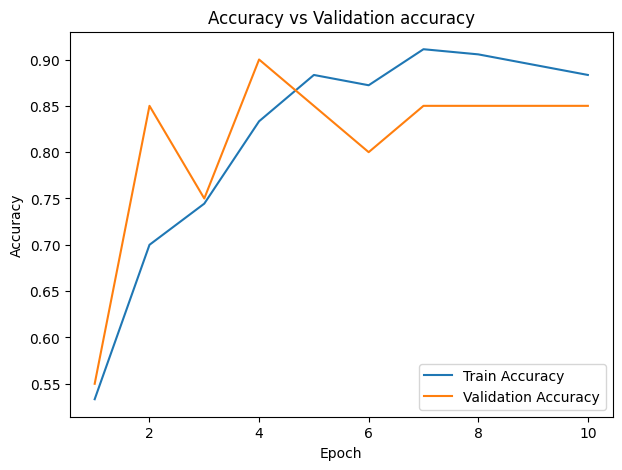

In [ ]:
perf_viewer(history)

## Evaluate the performance

In [ ]:
# Evaluate model Performance
simple_Conv.evaluate(x_train, y_train_en)

7/7 [==============================] - 0s 28ms/step - loss: 0.2087 - accuracy: 0.9050 - precision: 0.9091 - recall: 0.9000 - auc: 0.9877


[0.2087084949016571,
 0.9049999713897705,
 0.9090909361839294,
 0.8999999761581421,
 0.9877312779426575]

- upon evaluation of the performance of the model on the train set, we obtained the following metric scores:
- Accuracy = 0.90.
  - This means that 90% of the total predictions for the categories were correct.
- a loss of 0.209 was recorded

In [ ]:
from sklearn.metrics import classification_report



In [ ]:
#make predictions
y_pred = simple_Conv.predict(x_test)

#get the class of the predicted label
y_pred_class = y_pred.argmax(axis=1)
#get the class for thr test label
y_test_class = y_test_en.argmax(axis=1)

#display classification report
print(classification_report(y_test_class, y_pred_class))

2/2 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        23
           1       0.86      0.86      0.86        14
           2       0.93      0.93      0.93        14

    accuracy                           0.92        51
   macro avg       0.91      0.91      0.91        51
weighted avg       0.92      0.92      0.92        51



- the model had a precision of 1 for both categories 0 and 2. This means that all the predicitons for the categories were correct.
- the recall score of 0.96 for category 0 means that only 96% of the images for category 0 were rightly classified.
- In general, the precision and recall values for categories 1 and 2 respectively can be improved.

## Perform Data Augmentation

In [ ]:
#define an image datagenerator for the trainset and test set
train_datagen = ImageDataGenerator(vertical_flip=True,  rotation_range=0.4, zca_whitening=True)

test_datagen = ImageDataGenerator()


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [ ]:
#generate batches of augmented data and label for train and test
train_data = train_datagen.flow(x=x_train, y=y_train_en, seed=0)
test_data = test_datagen.flow(x_test, y_test_en, seed=0)

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
Conv2 = simpleConv()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 average_pooling2d (Average  (None, 16, 16, 128)       0         
 Pooling2D)                                                      
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1052291 (4.01 MB)
Trainable params: 1052291 (4.01 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
import os
es = EarlyStopping(monitor='auc', mode='max', verbose=2, patience=3)

#define modelcheckpoint to save best model
path = '/content/Drive/MyDrive/Covid_Image_Classification_Project'
cov_mc = ModelCheckpoint(filepath = os.path.join(path, 'cov_model'), save_best_only=True, monitor='val_auc', mode='max')

In [ ]:
history2 = Conv2.fit(train_data,epochs = 25, callbacks=[es, cov_mc], verbose=2, validation_data=test_data)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 3s - loss: 1.0783 - accuracy: 0.4700 - precision: 0.6122 - recall: 0.3000 - auc: 0.6896 - val_loss: 0.7961 - val_accuracy: 0.8824 - val_precision: 0.9474 - val_recall: 0.3529 - val_auc: 0.9319 - 3s/epoch - 408ms/step
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.7584 - accuracy: 0.6700 - precision: 0.7652 - recall: 0.5050 - auc: 0.8510 - val_loss: 0.6086 - val_accuracy: 0.7059 - val_precision: 0.7292 - val_recall: 0.6863 - val_auc: 0.9206 - 484ms/epoch - 69ms/step
Epoch 3/25
7/7 - 1s - loss: 0.5558 - accuracy: 0.7850 - precision: 0.8457 - recall: 0.6850 - auc: 0.9279 - val_loss: 0.4466 - val_accuracy: 0.8431 - val_precision: 0.8750 - val_recall: 0.8235 - val_auc: 0.9533 - 1s/epoch - 179ms/step
Epoch 4/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.4757 - accuracy: 0.8250 - precision: 0.8519 - recall: 0.8050 - auc: 0.9388 - val_loss: 0.4880 - val_accuracy: 0.8039 - val_precision: 0.7959 - val_recall: 0.7647 - val_auc: 0.9395 - 449ms/epoch - 64ms/step
Epoch 5/25
7/7 - 2s - loss: 0.4069 - accuracy: 0.8350 - precision: 0.8429 - recall: 0.8050 - auc: 0.9532 - val_loss: 0.3671 - val_accuracy: 0.8627 - val_precision: 0.8980 - val_recall: 0.8627 - val_auc: 0.9649 - 2s/epoch - 223ms/step
Epoch 6/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 1s - loss: 0.3625 - accuracy: 0.8350 - precision: 0.8549 - recall: 0.8250 - auc: 0.9631 - val_loss: 0.3465 - val_accuracy: 0.9020 - val_precision: 0.9020 - val_recall: 0.9020 - val_auc: 0.9689 - 1s/epoch - 185ms/step
Epoch 7/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 2s - loss: 0.3220 - accuracy: 0.8800 - precision: 0.8844 - recall: 0.8800 - auc: 0.9717 - val_loss: 0.2912 - val_accuracy: 0.9020 - val_precision: 0.9200 - val_recall: 0.9020 - val_auc: 0.9751 - 2s/epoch - 223ms/step
Epoch 8/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 2s - loss: 0.2885 - accuracy: 0.8700 - precision: 0.8878 - recall: 0.8700 - auc: 0.9775 - val_loss: 0.2794 - val_accuracy: 0.9216 - val_precision: 0.9400 - val_recall: 0.9216 - val_auc: 0.9797 - 2s/epoch - 267ms/step
Epoch 9/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.3041 - accuracy: 0.8700 - precision: 0.8827 - recall: 0.8650 - auc: 0.9736 - val_loss: 0.4013 - val_accuracy: 0.8039 - val_precision: 0.8039 - val_recall: 0.8039 - val_auc: 0.9549 - 480ms/epoch - 69ms/step
Epoch 10/25
7/7 - 1s - loss: 0.2990 - accuracy: 0.8900 - precision: 0.8980 - recall: 0.8800 - auc: 0.9754 - val_loss: 0.2627 - val_accuracy: 0.9216 - val_precision: 0.9200 - val_recall: 0.9020 - val_auc: 0.9824 - 1s/epoch - 177ms/step
Epoch 11/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.2783 - accuracy: 0.8950 - precision: 0.8974 - recall: 0.8750 - auc: 0.9785 - val_loss: 0.3110 - val_accuracy: 0.9216 - val_precision: 0.9216 - val_recall: 0.9216 - val_auc: 0.9741 - 469ms/epoch - 67ms/step
Epoch 12/25
7/7 - 1s - loss: 0.3110 - accuracy: 0.8800 - precision: 0.8889 - recall: 0.8800 - auc: 0.9728 - val_loss: 0.2322 - val_accuracy: 0.9216 - val_precision: 0.9400 - val_recall: 0.9216 - val_auc: 0.9866 - 1s/epoch - 181ms/step
Epoch 13/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.2505 - accuracy: 0.9000 - precision: 0.9086 - recall: 0.8950 - auc: 0.9833 - val_loss: 0.2673 - val_accuracy: 0.9216 - val_precision: 0.9216 - val_recall: 0.9216 - val_auc: 0.9796 - 467ms/epoch - 67ms/step
Epoch 14/25
7/7 - 0s - loss: 0.3331 - accuracy: 0.8500 - precision: 0.8543 - recall: 0.8500 - auc: 0.9708 - val_loss: 0.2502 - val_accuracy: 0.9608 - val_precision: 0.9592 - val_recall: 0.9216 - val_auc: 0.9864 - 473ms/epoch - 68ms/step
Epoch 15/25
7/7 - 1s - loss: 0.3294 - accuracy: 0.8700 - precision: 0.8731 - recall: 0.8600 - auc: 0.9712 - val_loss: 0.1982 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9927 - 1s/epoch - 179ms/step
Epoch 16/25


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


7/7 - 0s - loss: 0.2346 - accuracy: 0.9150 - precision: 0.9146 - recall: 0.9100 - auc: 0.9861 - val_loss: 0.2018 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9912 - 486ms/epoch - 69ms/step
Epoch 17/25
7/7 - 0s - loss: 0.2287 - accuracy: 0.9050 - precision: 0.9086 - recall: 0.8950 - auc: 0.9863 - val_loss: 0.2092 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9893 - 472ms/epoch - 67ms/step
Epoch 18/25
7/7 - 0s - loss: 0.2193 - accuracy: 0.9350 - precision: 0.9337 - recall: 0.9150 - auc: 0.9887 - val_loss: 0.1962 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9909 - 473ms/epoch - 68ms/step
Epoch 19/25
7/7 - 0s - loss: 0.2166 - accuracy: 0.9200 - precision: 0.9196 - recall: 0.9150 - auc: 0.9877 - val_loss: 0.2226 - val_accuracy: 0.9412 - val_precision: 0.9412 - val_recall: 0.9412 - val_auc: 0.9882 - 449ms/epoch - 64ms/step
Epoch 20/25
7/7 - 0s - loss: 0.2142 - accuracy: 0.9250 - precisi

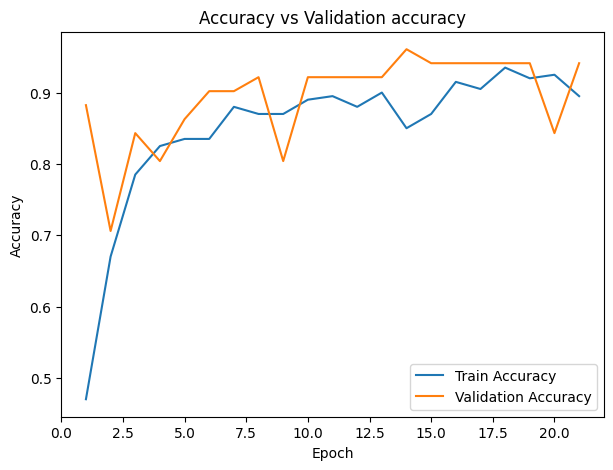

In [ ]:
perf_viewer(history2)

## Finalize Model
- This involves evaluating the model on the entire dataset.

In [ ]:
#get the saved labelBinarizer
import pickle
lb_path='/content/Drive/MyDrive/Covid_Image_Classification_Project/label_binarizer.pkl'
with open(lb_path, mode='rb') as lb_file:
  lb = pickle.load(lb_file)

In [ ]:
#encode the entire labels
labels_en= lb.transform(labels)

In [ ]:
#evaluate model performance on the entire data
perf = Conv2.evaluate(image_normalized, labels_en)

8/8 [==============================] - 0s 27ms/step - loss: 0.2238 - accuracy: 0.9163 - precision: 0.9303 - recall: 0.9044 - auc: 0.9865


In [ ]:
#make predicition
preds = Conv2.predict(image_normalized)

#get the class of the predicted label
pred_class = preds.argmax(axis=1)
#get the class for the test label
labels_class = labels_en.argmax(axis=1)

#display classification report
print(classification_report(labels_class, pred_class))

8/8 [==============================] - 0s 27ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       111
           1       0.90      0.81      0.86        70
           2       0.89      0.93      0.91        70

    accuracy                           0.92       251
   macro avg       0.91      0.91      0.91       251
weighted avg       0.92      0.92      0.92       251



- the model shows a precision score of 0.94, 0.90, and 0.89 for class 0,1, and 2 respectively which means that 94%, 90% and 89% of the predictions for category 0, 1 and 2 were accurate.
- the model also shows a recall score of 0.97, 0.81, and 0.93 for class 0,1, and 2 respectively which means that the model was able correctly classify 97%, 81% and 93% of each of the class 0,1 and 2 respectively in the dataset.

## This is the BEST MODEL so far.